<h1> <U><B>INTERCART MARKET BASKET ANALYSIS

## RESUMO

###  SOBRE O PROJETO

Esse projeto irá ajudar no entendimento de conceitos matemáticos para Análise e Ciência de Dados.

"Nosso objetivo deste projeto é identificar associação entre produtos de uma cesta de compras. Qyem compra o Produto A, também compra o Produto B? Qual a força dessa relação, se ela existir?

Vamos analisar dados de milhões de transações aplicando Market Basket Analysis."

<b>Data Science Academy </b>

###  SOBRE MATEMÁTICA E ESTATÍSTICA DESCRITIVA PARA ANÁLISE DE DADOS

Os principais conhecimentos matemáticos necessários para Análise de Dados são <u>operações aritméticas</u> e <u>operações com matrizes</u>. 

Já os conhecimentos estatísticos necessários para Análise de Dados são <u>cálculo de frequências absoluta</u>, <u>relativa e acumulada, medidas de tendência central (média, mediana e moda)</u>, <u>cálculo de correlação, variância e covariância</u>, <u>distribuições de probabilidade</u>, <u>coeficientes de correlação</u> e <u>medidas de dispersão (desvio padrão e variância)</u>.

##  IMPORTS

In [1]:
# Imports
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from itertools import combinations
import efficient_apriori
from efficient_apriori import apriori
import warnings
warnings.filterwarnings('ignore')

##  CARREGAMENTO DOS DADOS

In [2]:
# Carrega os dados
aisle = pd.read_csv('dados/aisles.csv') # corredor_id e descrição do corredor
department = pd.read_csv('dados/departments.csv') # departamento_id e descrição do departamento
order = pd.read_csv('dados/orders.csv') # dados do pedido, incluindo id
product = pd.read_csv('dados/products.csv') # produto_id, nome do produto, corredor e departamento
order_product_prior = pd.read_csv('dados/order_products__prior.csv') # espécie subset de order
order_product_train = pd.read_csv('dados/order_products__train.csv')

##  ANÁLISE EXPLORATÓRIA

In [3]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [4]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [5]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [7]:
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [8]:
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


Total de registros em cada dataset:

In [9]:
datasets_linhas_colunas = np.array([['aisle', aisle.shape[0],aisle.shape[1]],
                     ['department', department.shape[0],department.shape[1]],
                     ['order', order.shape[0],order.shape[1]],
                     ['product', product.shape[0],product.shape[1]],
                     ['order_product_prior', order_product_prior.shape[0],order_product_prior.shape[1]],
                     ['order_product_train', order_product_train.shape[0],order_product_train.shape[1]]])

In [10]:
df_linhas_colunas = pd.DataFrame(datasets_linhas_colunas, 
                                 columns = ['Dataset', 'Linhas', 'Colunas'])
df_linhas_colunas

,Dataset,Linhas,Colunas
0,aisle,134,2
1,department,21,2
2,order,3421083,7
3,product,49688,4
4,order_product_prior,32434489,4
5,order_product_train,1384617,4


##  LIMPEZA DOS DADOS

###  VERIFICAÇÃO DE VALORES AUSENTES

Esse dataset já está bem organizado e limpo. Mas, mesmo assim, vamos verificar os valores nulos:

In [11]:
aisle.isna().sum()

aisle_id    0
aisle       0
dtype: int64

In [12]:
department.isna().sum()

department_id    0
department       0
dtype: int64

In [13]:
order.isna().sum()

order_id                       0
user_id                        0
eval_set                       0
order_number                   0
order_dow                      0
order_hour_of_day              0
days_since_prior_order    206209
dtype: int64

In [14]:
product.isna().sum()

product_id       0
product_name     0
aisle_id         0
department_id    0
dtype: int64

In [15]:
order_product_prior.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

In [16]:
order_product_train.isna().sum()

order_id             0
product_id           0
add_to_cart_order    0
reordered            0
dtype: int64

O único dataset que possui valores ausentes é "order". São 206209 valores ausentes na coluna "days_since_prior_order", que representa o número de dias desde que o usuário/cliente fez o pedido anterior. Mas, caso o cliente esteja fazendo sua primeira compra, obviamente não há pedido anterior. Logo, essa variável fica "vazia".

Se pensarmos em nível de dado, sim, temos um valor nulo. Mas em relação à informação, não temos sua ausência, pois temos representado a informação de que o cliente nunca efetuou nenhuma compra no site.

###  FEATURE EXTRACTION

Não faz sentido analisar os datasets de maneira individual. Sendo assim, podemos concatenar os dados usando merge.

As concatenações serão feitas entre order_product_prior e aisle, department, order, product e, depois, entre order_product_train e aisle, department, order, product.

####  Merge para order_product_prior

In [17]:
# head dos datasets order_product_prior, order, product, aisle, department
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [18]:
order.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [19]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


In [20]:
aisle.head()

,aisle_id,aisle
0,1,prepared soups salads
1,2,specialty cheeses
2,3,energy granola bars
3,4,instant foods
4,5,marinades meat preparation


In [21]:
department.head()

,department_id,department
0,1,frozen
1,2,other
2,3,bakery
3,4,produce
4,5,alcohol


In [22]:
# merge
order_product_prior = order_product_prior.merge(order, on = 'order_id', how = 'left')
order_product_prior = order_product_prior.merge(product, on = 'product_id', how = 'left')
order_product_prior = order_product_prior.merge(aisle, on = 'aisle_id', how = 'left')
order_product_prior = order_product_prior.merge(department, on = 'department_id', how = 'left')

In [23]:
# head
order_product_prior.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,2,33120,1,1,202279,prior,3,5,9,8.0,Organic Egg Whites,86,16,eggs,dairy eggs
1,2,28985,2,1,202279,prior,3,5,9,8.0,Michigan Organic Kale,83,4,fresh vegetables,produce
2,2,9327,3,0,202279,prior,3,5,9,8.0,Garlic Powder,104,13,spices seasonings,pantry
3,2,45918,4,1,202279,prior,3,5,9,8.0,Coconut Butter,19,13,oils vinegars,pantry
4,2,30035,5,0,202279,prior,3,5,9,8.0,Natural Sweetener,17,13,baking ingredients,pantry


In [24]:
# qtde de valores ausentes
order_product_prior.isna().sum()

order_id                        0
product_id                      0
add_to_cart_order               0
reordered                       0
user_id                         0
eval_set                        0
order_number                    0
order_dow                       0
order_hour_of_day               0
days_since_prior_order    2078068
product_name                    0
aisle_id                        0
department_id                   0
aisle                           0
department                      0
dtype: int64

In [25]:
# porcentagem de valores ausentes
(order_product_prior.isna().sum() / len(order_product_prior)) * 100

order_id                  0.00000
product_id                0.00000
add_to_cart_order         0.00000
reordered                 0.00000
user_id                   0.00000
eval_set                  0.00000
order_number              0.00000
order_dow                 0.00000
order_hour_of_day         0.00000
days_since_prior_order    6.40697
product_name              0.00000
aisle_id                  0.00000
department_id             0.00000
aisle                     0.00000
department                0.00000
dtype: float64

A variável days_since_prior_order possui aproximadamente 6,4% valores ausentes. Isso não justifica a exclusão dessa variável. Contudo, ela não será usada no MBA.

####  Merge para order_product_train

In [26]:
# head dos datasets
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered
0,1,49302,1,1
1,1,11109,2,1
2,1,10246,3,0
3,1,49683,4,0
4,1,43633,5,1


In [27]:
# merge
order_product_train = order_product_train.merge(order, on = 'order_id', how = 'left')
order_product_train = order_product_train.merge(product, on = 'product_id', how = 'left')
order_product_train = order_product_train.merge(aisle, on = 'aisle_id', how = 'left')
order_product_train = order_product_train.merge(department, on = 'department_id', how = 'left')

In [28]:
# head
order_product_train.head()

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,aisle,department
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,yogurt,dairy eggs
1,1,11109,2,1,112108,train,4,4,10,9.0,Organic 4% Milk Fat Whole Milk Cottage Cheese,108,16,other creams cheeses,dairy eggs
2,1,10246,3,0,112108,train,4,4,10,9.0,Organic Celery Hearts,83,4,fresh vegetables,produce
3,1,49683,4,0,112108,train,4,4,10,9.0,Cucumber Kirby,83,4,fresh vegetables,produce
4,1,43633,5,1,112108,train,4,4,10,9.0,Lightly Smoked Sardines in Olive Oil,95,15,canned meat seafood,canned goods


In [29]:
# qtde de valores ausentes
order_product_train.isna().sum()

order_id                  0
product_id                0
add_to_cart_order         0
reordered                 0
user_id                   0
eval_set                  0
order_number              0
order_dow                 0
order_hour_of_day         0
days_since_prior_order    0
product_name              0
aisle_id                  0
department_id             0
aisle                     0
department                0
dtype: int64

####  Agrupamento dos dados

Podemos agrupar os produtos comprados de acordo com o pedido.

In [30]:
# agrupar o id do produto de acordo com o id do pedido
# jogar em um df
produto_por_pedido = pd.DataFrame(order_product_prior.groupby('order_id')['product_id'])

In [31]:
# shape
produto_por_pedido.shape

(3214874, 2)

In [32]:
# head
produto_por_pedido.head()

,0,1
0,2,0 33120 1 28985 2 9327 3 45918 4 ...
1,3,9 33754 10 24838 11 17704 12 2190...
2,4,17 46842 18 26434 19 39758 20 2776...
3,5,30 13176 31 15005 32 47329 33 2796...
4,6,56 40462 57 15873 58 41897 Name: prod...


Os valores da coluna "1" do dataframe não estão limpos. Não temos apenas o código do produto comprado no pedido em questão, mas também

In [33]:
prod = []

In [34]:
for i in range(len(produto_por_pedido[0])):
    prod.append(list(produto_por_pedido.iloc[i][1]))

In [35]:
# cria o dataframe com as transações
transacoes = pd.DataFrame({'OrderID' : produto_por_pedido[0], 'Products' : prod})

In [36]:
transacoes.head(10)

,OrderID,Products
0,2,"[33120, 28985, 9327, 45918, 30035, 17794, 4014..."
1,3,"[33754, 24838, 17704, 21903, 17668, 46667, 174..."
2,4,"[46842, 26434, 39758, 27761, 10054, 21351, 225..."
3,5,"[13176, 15005, 47329, 27966, 23909, 48370, 132..."
4,6,"[40462, 15873, 41897]"
5,7,"[34050, 46802]"
6,8,[23423]
7,9,"[21405, 47890, 11182, 2014, 29193, 34203, 1499..."
8,10,"[24852, 4796, 31717, 47766, 4605, 1529, 21137,..."
9,11,"[30162, 27085, 5994, 1313, 31506]"


O que vemos no dataframe acima é: para o pedido de id 2, quais foram os pedidos comprados? E, assim, sucessivamente.  

Esse agrupamento de produtos de acordo com o número do pedido, nesse formato, vai ser importante para o algoritmo "apriori", pois ele espera receber as transações para fazer sua análise.

Mas, antes de partir para o algoritmo, vamos fazer uma análise estatística descritiva sobre os dados.

##  ANÁLISE ESTATÍSTICA DESCRITIVA

###   1- Qual o Número de Pedidos (quantidade de pedidos) Mais Frequente Entre os Usuários?

In [37]:
order_max = order.groupby('user_id')['order_number'].aggregate(np.max).reset_index()
order_max.head()

,user_id,order_number
0,1,11
1,2,15
2,3,13
3,4,6
4,5,5


In [38]:
order_max['order_number'].mode()

0    4
dtype: int64

In [39]:
contagem_num_pedidos = order_max['order_number'].value_counts()
contagem_num_pedidos

4     23986
5     19590
6     16165
7     13850
8     11700
      ...  
94       57
91       56
97       54
98       50
99       47
Name: order_number, Length: 97, dtype: int64

A maioria dos usuários fez 4 pedidos, exatamente em 23986 pedidos. Mas podemos colocar isso em um gráfico.

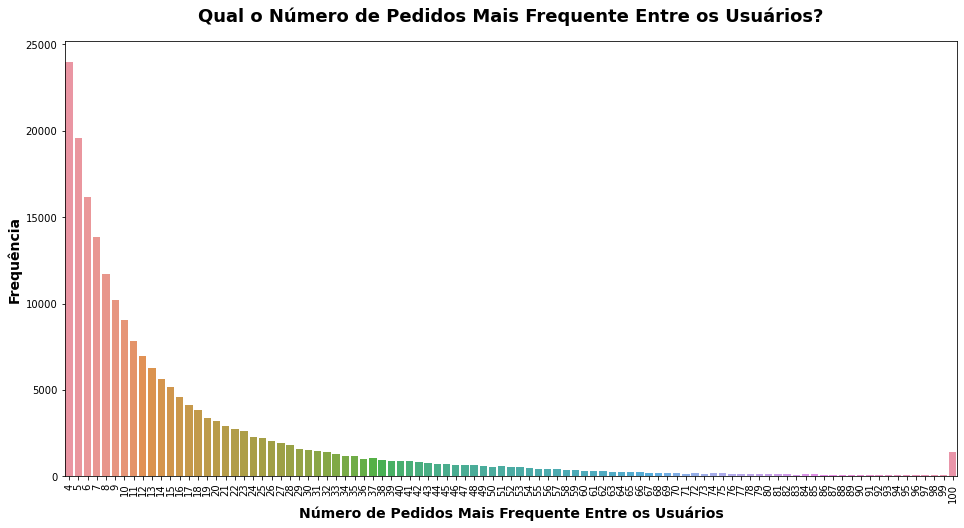

In [40]:
ax = sns.barplot(x = contagem_num_pedidos.index, y = contagem_num_pedidos.values)
ax.figure.set_size_inches(16,8)
plt.title('Qual o Número de Pedidos Mais Frequente Entre os Usuários?', fontsize = 18, pad = 20,
         fontweight = 'bold')
plt.xticks(rotation = 'vertical')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xlabel('Número de Pedidos Mais Frequente Entre os Usuários', fontsize = 14, fontweight = 'bold')
plt.show()

###   2- Qual Dia da Semana Tem o Maior Número de Pedidos?

In [41]:
max_pedidos_semana = order.groupby(['order_id','order_dow'])['order_number'].aggregate(np.sum).reset_index()
max_pedidos_semana.head()

,order_id,order_dow,order_number
0,1,4,4
1,2,5,3
2,3,5,16
3,4,1,36
4,5,6,42


In [42]:
max_pedidos_dia_semana = max_pedidos_semana.order_dow.value_counts()
max_pedidos_dia_semana

0    600905
1    587478
2    467260
5    453368
6    448761
3    436972
4    426339
Name: order_dow, dtype: int64

Vemos que os domingos e as segundas-feiras, representados, respectivamente, pelos números 0 e 1, são os dias da semana onde há mais pedidos. Mas podemos colocar esses números em um gráfico.

In [43]:
x = [0,1,2,3,4,5,6]

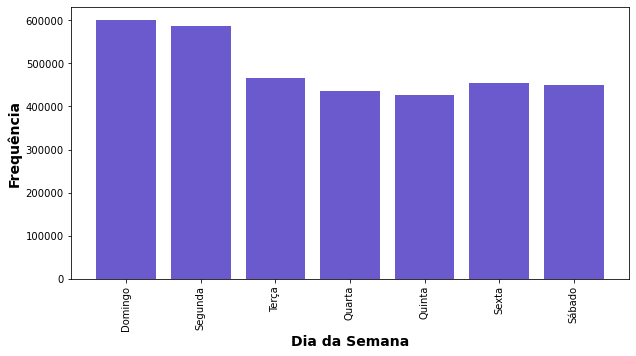

In [44]:
plt.figure(figsize = (10,5))
plt.bar(max_pedidos_dia_semana.index,max_pedidos_dia_semana.values, color = 'slateblue')
plt.xlabel('Dia da Semana', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.xticks(x,['Domingo', 'Segunda', 'Terça', 'Quarta', 'Quinta', 'Sexta', 'Sábado'], rotation = 'vertical')
plt.show()

###   3 - Qual Hora do Dia Tem o Maior Número de Pedidos?

In [45]:
pedidos_id_hora = order.groupby(['order_id', 'order_hour_of_day'])['order_number'].aggregate(np.sum).reset_index()
pedidos_id_hora.head()

,order_id,order_hour_of_day,order_number
0,1,10,4
1,2,9,3
2,3,17,16
3,4,9,36
4,5,16,42


In [46]:
freq_pedidos_hora = pedidos_id_hora.order_hour_of_day.value_counts()

In [47]:
x = freq_pedidos_hora.index
y = freq_pedidos_hora.values

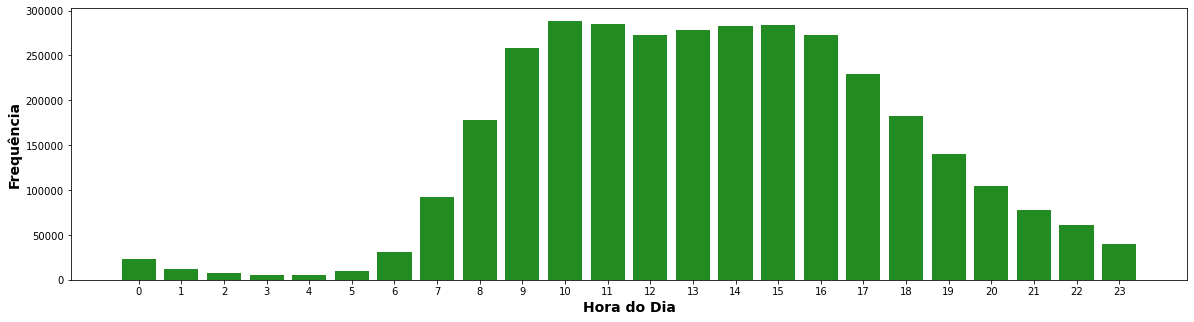

In [48]:
plt.figure(figsize = (20,5))
plt.bar(x,y,color = 'forestgreen')
plt.xticks(np.arange(0,24,1))
plt.xlabel('Hora do Dia', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

O horário de 10 da manhã possui o  maior número de pedidos.

###   4 - Qual Departamento Tem o Maior Número de Produtos em Pedidos?

In [49]:
peds_por_dpto = order_product_prior['department'].value_counts()

In [50]:
peds_por_dpto

produce            9479291
dairy eggs         5414016
snacks             2887550
beverages          2690129
frozen             2236432
pantry             1875577
bakery             1176787
canned goods       1068058
deli               1051249
dry goods pasta     866627
household           738666
breakfast           709569
meat seafood        708931
personal care       447123
babies              423802
international       269253
alcohol             153696
pets                 97724
missing              69145
other                36291
bulk                 34573
Name: department, dtype: int64

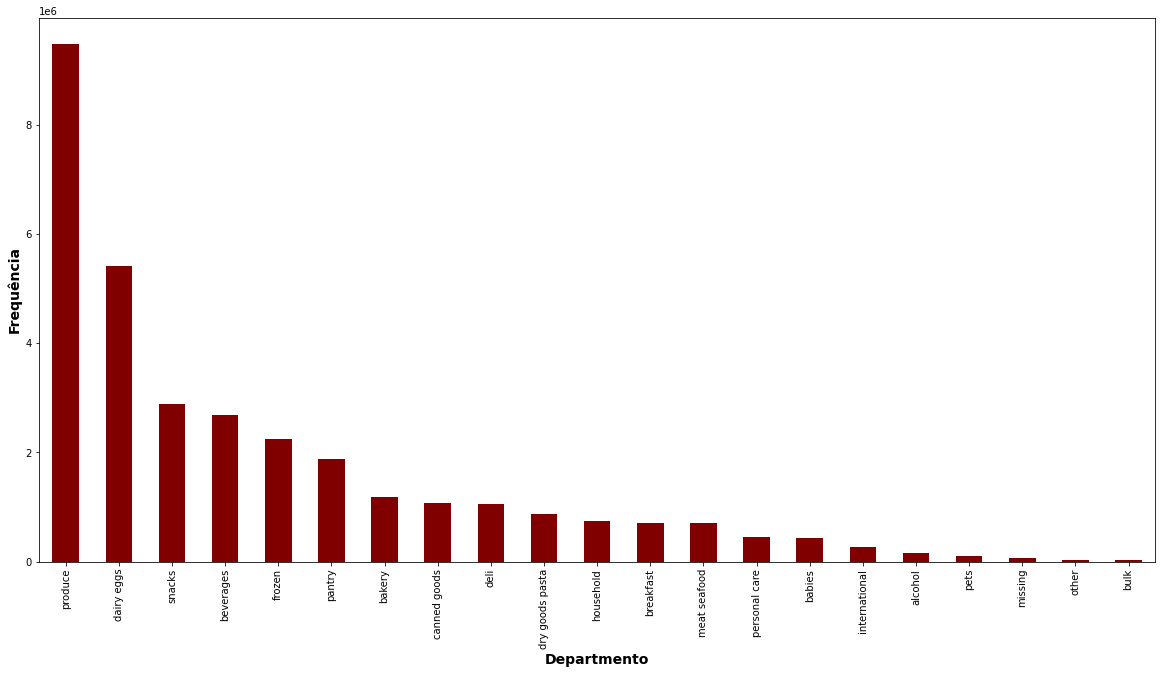

In [51]:
# Plot
fig = plt.figure(figsize = (20,10))
peds_por_dpto.plot(kind = "bar", color = 'maroon')
plt.xticks(rotation = 90)
plt.xlabel('Departmento', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

###   5 - Quais os 20 Principais Corredores Por Frequência de Pedidos?

In [52]:
len(aisle.aisle.unique())

134

In [53]:
vinte_corredores = (order_product_prior['aisle'].value_counts()).head(20)
vinte_corredores

fresh fruits                     3642188
fresh vegetables                 3418021
packaged vegetables fruits       1765313
yogurt                           1452343
packaged cheese                   979763
milk                              891015
water seltzer sparkling water     841533
chips pretzels                    722470
soy lactosefree                   638253
bread                             584834
refrigerated                      575881
frozen produce                    522654
ice cream ice                     498425
crackers                          458838
energy granola bars               456386
eggs                              452134
lunch meat                        395130
frozen meals                      390299
baby food formula                 382456
fresh herbs                       377741
Name: aisle, dtype: int64

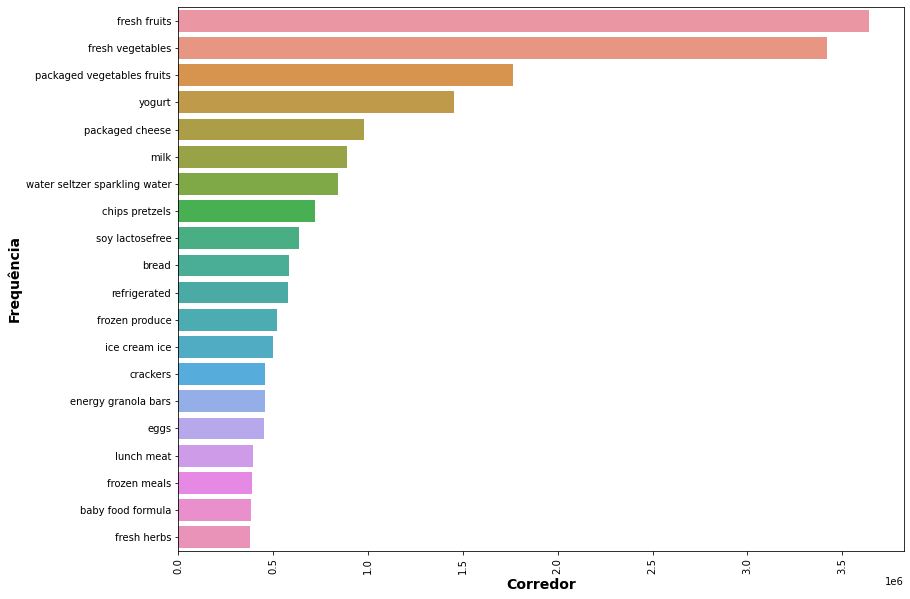

In [54]:
fig = plt.figure(figsize = (13,10))
sns.barplot(y = vinte_corredores.index, x = vinte_corredores.values, orient = 'h')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

###  6 - Quais os 20 Principais Produtos Por Frequência de Pedidos?

In [55]:
len(product.product_name.unique())

49688

In [56]:
vinte_produtos = (order_product_prior['product_name'].value_counts()).head(20)
vinte_produtos

Banana                      472565
Bag of Organic Bananas      379450
Organic Strawberries        264683
Organic Baby Spinach        241921
Organic Hass Avocado        213584
Organic Avocado             176815
Large Lemon                 152657
Strawberries                142951
Limes                       140627
Organic Whole Milk          137905
Organic Raspberries         137057
Organic Yellow Onion        113426
Organic Garlic              109778
Organic Zucchini            104823
Organic Blueberries         100060
Cucumber Kirby               97315
Organic Fuji Apple           89632
Organic Lemon                87746
Apple Honeycrisp Organic     85020
Organic Grape Tomatoes       84255
Name: product_name, dtype: int64

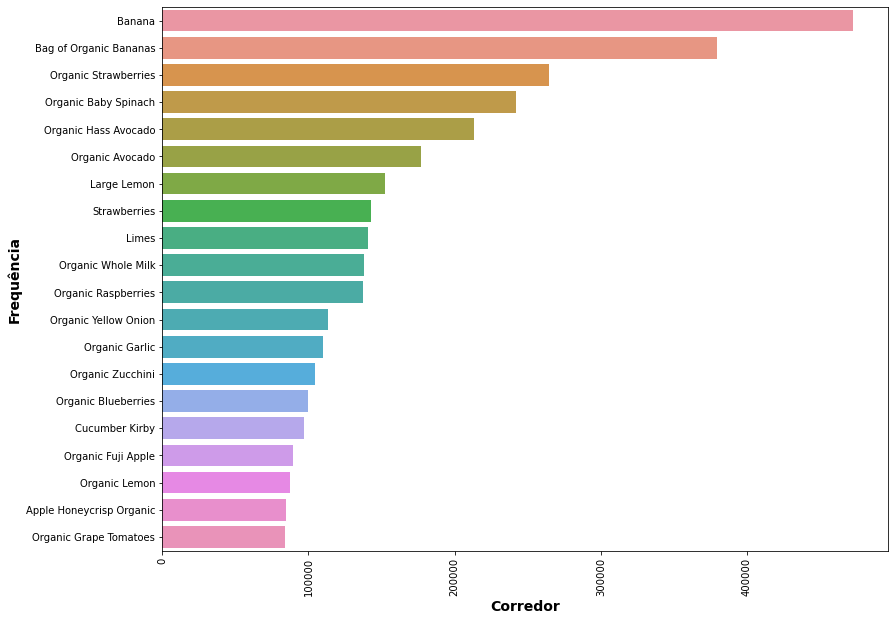

In [57]:
fig = plt.figure(figsize = (13,10))
sns.barplot(y = vinte_produtos.index, x = vinte_produtos.values, orient = 'h')
plt.xticks(rotation = 90)
plt.xlabel('Corredor', fontsize = 14, fontweight = 'bold')
plt.ylabel('Frequência', fontsize = 14, fontweight = 'bold')
plt.show()

In [58]:
product.head()

,product_id,product_name,aisle_id,department_id
0,1,Chocolate Sandwich Cookies,61,19
1,2,All-Seasons Salt,104,13
2,3,Robust Golden Unsweetened Oolong Tea,94,7
3,4,Smart Ones Classic Favorites Mini Rigatoni Wit...,38,1
4,5,Green Chile Anytime Sauce,5,13


###   7 a) - Análise de Novos Pedidos Semelhantes a Pedidos Anteriores (reorder)

Imaginemos a seguinte situação: um usuário fez um primeiro pedido. 3 semanas depois, ele retornou ao site e fez um segundo pedido. Quanta semelhança há entre esses pedidos? Ele está comprando os mesmos produtos? Lembrando que no dataset "order_product_prior" existe a coluna "reordered", que sinaliza se o produto está sendo comprado novamente ou não.

Vamos analisar.

O dataframe abaixo terá o nome do produto, o total de pedidos com ele e o número de vezes em que foi comprado novamente.

Após a criação do dataframe, vamos encontrar os 20 primeiros produtos dele.

In [59]:
# agrupar reordered de acordo com o nome do produto
# funções de contagem e soma
# renomear as colunas (contagem e soma)
# depois, reorndenar os valores 
temp_df = order_product_prior.groupby('product_name')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total','sum':'reorders'})
temp_df.sort_values('total', ascending = False, inplace = True)

In [60]:
temp_df.head()

,total,reorders
product_name,,
Banana,472565,398609
Bag of Organic Bananas,379450,315913
Organic Strawberries,264683,205845
Organic Baby Spinach,241921,186884
Organic Hass Avocado,213584,170131


In [61]:
# listas: nomes dos produtos; comprados novamente; total
nomes_produtos = list(temp_df.index.values[:20])
reorders = list(temp_df.reorders.values[:20])
total = list(temp_df.total.values[:20])

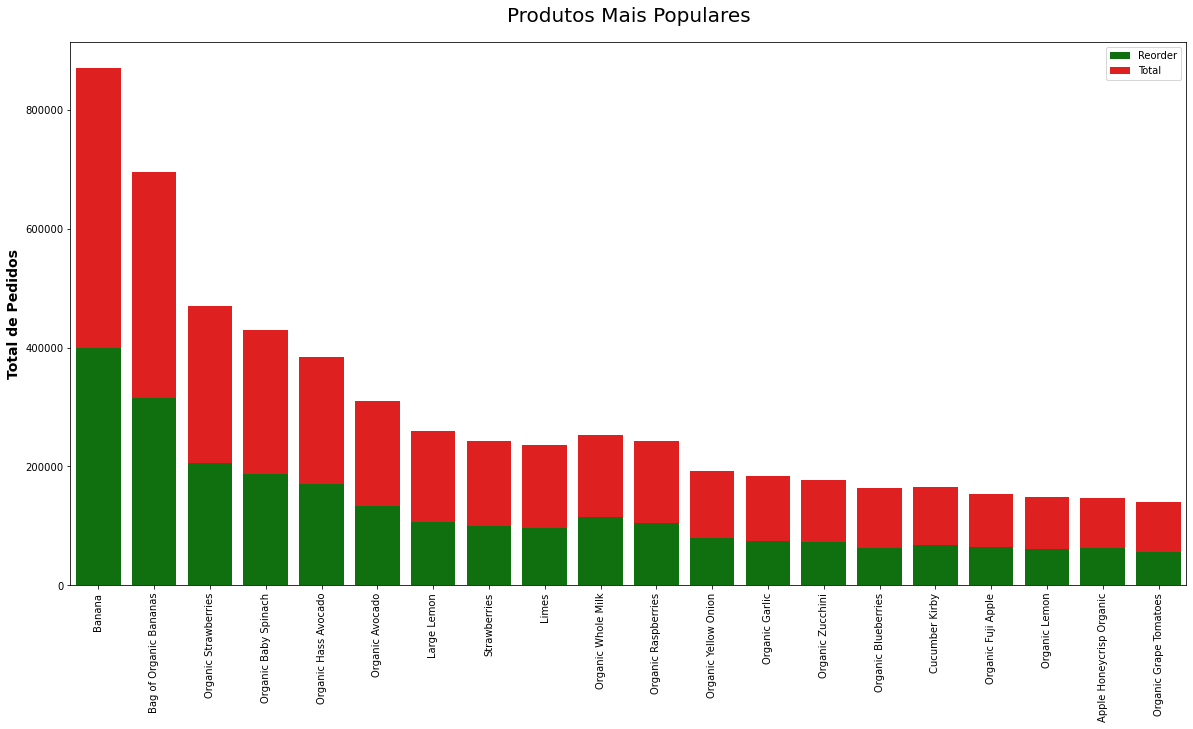

In [62]:
# gráfico
width = 0.35 
plt.subplots(figsize = (20,10))
ax = sns.barplot(nomes_produtos, reorders, label = 'Reorder', color = 'green')
ax = sns.barplot(nomes_produtos, total, bottom = reorders, label = 'Total', color = 'red')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Produtos Mais Populares", fontsize = 20, pad = 20)
plt.xticks(rotation = 90)
plt.show();

O gráfico Stacked Bar acima nos mostra que, pelo menos em relação aos 20 produtos mais vendidos, os usuários voltam para compras os mesmos produtos. Esse entendimento vêm a partir da percepção de que as proporções de cada parte das barras são muito parecidas (total de produtos comprados, comprados novamente).

###   7 b) - Porcentagem de Reorder Por Departamento ao Longo do Tempo

In [63]:
# agrupar os dados por departamento e reorder
# usar a média
temp_df = order_product_prior.groupby('department')['reordered'].agg('mean').reset_index()

In [64]:
# head
temp_df.head(10)

,department,reordered
0,alcohol,0.569924
1,babies,0.578971
2,bakery,0.628141
3,beverages,0.653460
4,breakfast,0.560922
5,bulk,0.577040
6,canned goods,0.457405
7,dairy eggs,0.669969
8,deli,0.607719
9,dry goods pasta,0.461076


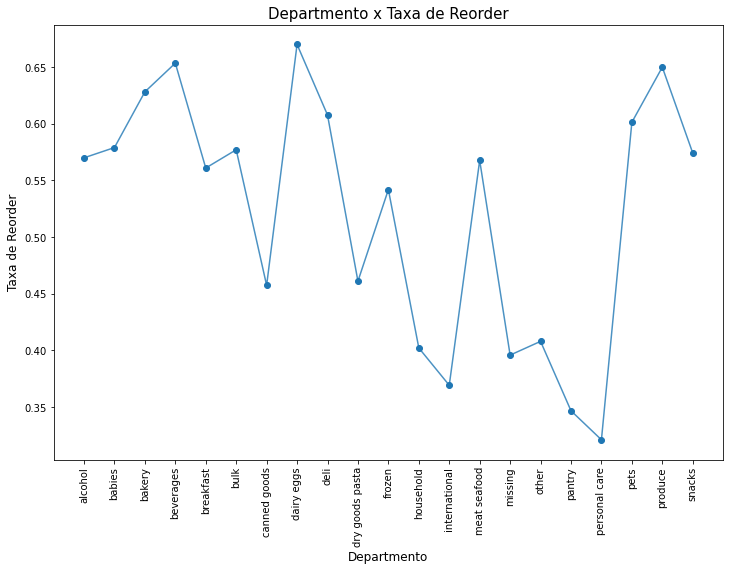

In [65]:
# plot
plt.figure(figsize = (12,8))
plt.plot(list(temp_df['department']), temp_df['reordered'].values, alpha=0.8)
plt.scatter(list(temp_df['department']), temp_df['reordered'].values)
plt.ylabel('Taxa de Reorder', fontsize = 12)
plt.xlabel('Departmento', fontsize = 12)
plt.title("Departmento x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

Aqui vemos a oscilação da taxa de reorder (recompra) de acordo com o departamento. Esse é um exemplo de técnica que as empresas podem utilizar para melhor gerenciar seus estoques.

###   8 - Análise de Reorder e Pedidos por Departamento

In [66]:
# agrupamento de reorders por departamento
# usar funções count e sum
# renomear colunas
# reordenar valores 
# resetar indice
temp_df = order_product_prior.groupby('department')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [67]:
# head
temp_df.head()

,department,total,reorders
0,produce,9479291,6160710
1,dairy eggs,5414016,3627221
2,snacks,2887550,1657973
3,beverages,2690129,1757892
4,frozen,2236432,1211890


In [68]:
# listas com os 20 primeiros
nomes_produtos = list(temp_df.department.values[:20])
reorders = list(temp_df.reorders.values[:20])
total = list(temp_df.total.values[:20])

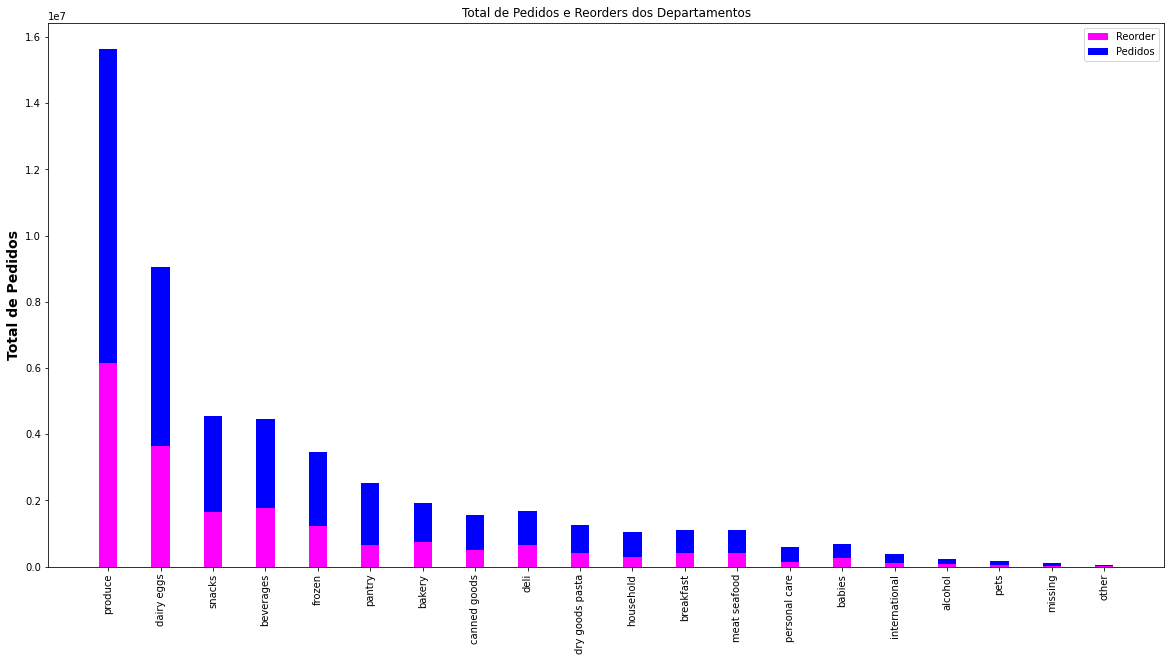

In [69]:
# plot (stacked bar)
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(nomes_produtos, reorders, width, label = 'Reorder', color = 'magenta')
ax.bar(nomes_produtos, total, width, bottom = reorders, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Departamentos")
plt.xticks(rotation = 90)
plt.show()

O gráfico acima, que mostra a proporção de pedidos e recompras de acordo com o departamento, reforça a tendência de que um cliente volta e faça novas compras dos mesmos produtos em outras oportunidades.

###   9 - Análise de Reorder Por Corredor (taxa média)

In [70]:
# agrupamento de reorders por corredor
# usar função mean
# resetar indice
temp_df = order_product_prior.groupby('aisle')['reordered'].agg(['mean']).reset_index()
temp_df.columns = ['corredor', 'taxa recompra']

In [71]:
# head
# listas com os 20 primeiros
lista = temp_df.head(20)
lista

,corredor,taxa recompra
0,air fresheners candles,0.309052
1,asian foods,0.351132
2,baby accessories,0.550980
3,baby bath body care,0.295770
4,baby food formula,0.590259
5,bakery desserts,0.499125
6,baking ingredients,0.305082
7,baking supplies decor,0.167229
8,beauty,0.212062
9,beers coolers,0.565304


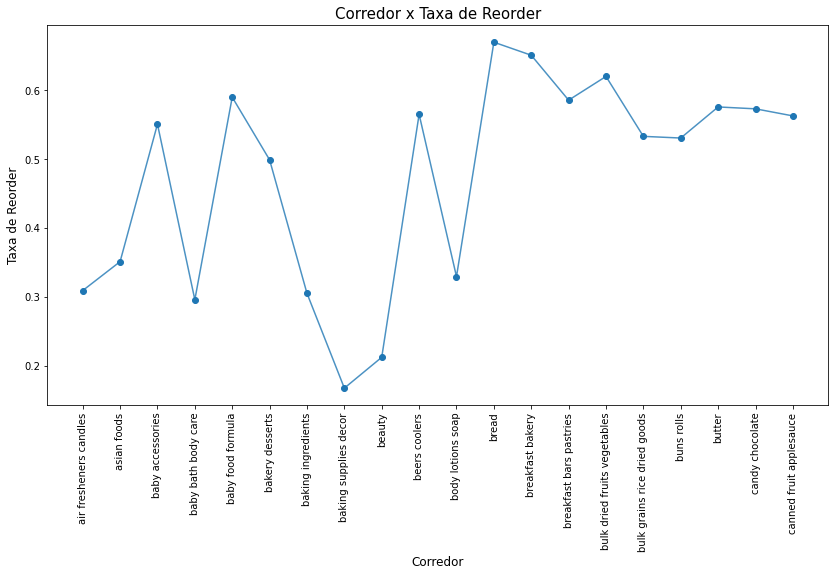

In [72]:
# plot (line)
plt.figure(figsize=(14,7))
plt.plot(list(lista['corredor']), lista['taxa recompra'].values, alpha=0.8)
plt.scatter(list(lista['corredor']), lista['taxa recompra'].values)
plt.ylabel('Taxa de Reorder', fontsize=12)
plt.xlabel('Corredor', fontsize=12)
plt.title("Corredor x Taxa de Reorder", fontsize = 15)
plt.xticks(rotation = 'vertical')
plt.show()

###   10 - Análise de Reorder Por Corredor (Total)

In [73]:
temp_df = order_product_prior.groupby('aisle')['reordered'].agg(['count', 'sum']).rename(columns = {'count':'total', 'sum':'reorders'})
temp_df = temp_df.sort_values('total', ascending = False).reset_index()

In [74]:
# head
temp_df.head()

,aisle,total,reorders
0,fresh fruits,3642188,2615469
1,fresh vegetables,3418021,2032172
2,packaged vegetables fruits,1765313,1127177
3,yogurt,1452343,997018
4,packaged cheese,979763,573383


In [75]:
# listas com os 20 primeiros
nomes_produtos = list(temp_df.aisle.values[:20])
reorders = list(temp_df.reorders.values[:20])
total = list(temp_df.total.values[:20])

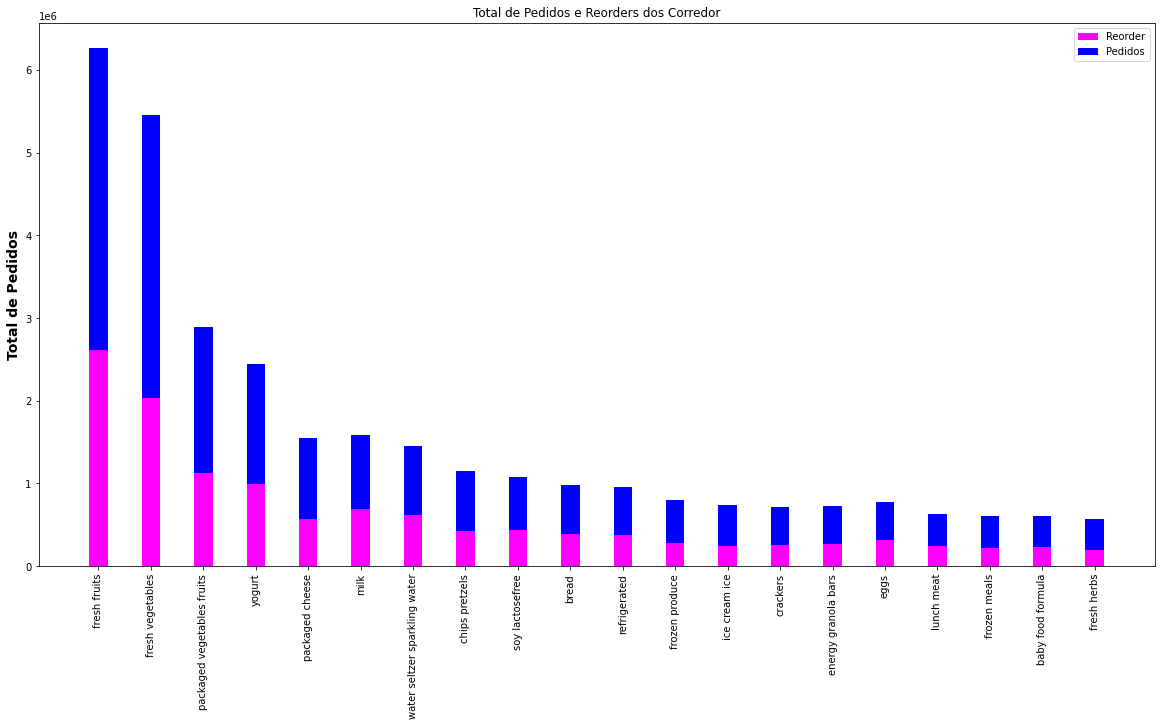

In [76]:
# plot (stacked bar)
width = 0.35  
fig, ax = plt.subplots(figsize = (20,10))
ax.bar(nomes_produtos, reorders, width, label = 'Reorder', color = 'magenta')
ax.bar(nomes_produtos, total, width, bottom = reorders, label = 'Pedidos', color = 'blue')
ax.set_ylabel('Total de Pedidos', fontsize = 14, fontweight = 'bold')
ax.legend()
ax.set_title("Total de Pedidos e Reorders dos Corredor")
plt.xticks(rotation = 90)
plt.show()

Esse último gráfico mostra, afinal, que há um padrão de compras. Caso não existisse um padrão, não seria interessante continuar com a análise, muito menos utilizar o algoritmo "apriori". Nenhum algoritmo tem utilidade sem padrão.

###  Vamos verificar a relação entre como a ordem de adição do produto ao carrinho afeta a proporção de novos pedidos

In [77]:
# criando uma cópia do dataframe order_product_prior
order_product_prior["add_to_cart_order_mod"] = order_product_prior["add_to_cart_order"].copy()

In [78]:
# produtos que foram adicionados mais de 70 vezes
order_product_prior["add_to_cart_order_mod"].loc[order_product_prior["add_to_cart_order_mod"] > 70] = 70

In [79]:
# taxa média de recompra do produto, de acordo com a ordem em que foi colocado no carrinho 
grouped_df = order_product_prior.groupby(["add_to_cart_order_mod"])["reordered"].aggregate("mean").reset_index()

In [80]:
grouped_df.head(10)

,add_to_cart_order_mod,reordered
0,1,0.677533
1,2,0.676251
2,3,0.658037
3,4,0.636958
4,5,0.617383
5,6,0.600420
6,7,0.585687
7,8,0.573247
8,9,0.561474
9,10,0.551018


Produtos forem os primeiros a serem inseridos nos carrinhos na hora da compra, foram recomprados, em porcentagem média, em 67.75% das vezes.

##  IMPLEMENTAÇÃO DO ALGORITMO APRIORI

O algoritmo Apriori implementa a regra de associação. Ele não é um algoritmo de Machine Learning, mas sim de mineração de dados, que descobre padrões. 

Apriori utiliza 3 métricas para descobrir padrões: support, confidence e lift. Um pouco sobre cada:

* support ➝ fração de transações que contêm A e B ((A + B) / Total). 
* confidence ➝ a frequência com que B aparece em transações que contêm apenas A ((A + B) / A).
* lift ➝ quanto aumentou nossa confiança de que B será comprado, dado que A foi comprado (B será comprado, já que A já está no carrinho?).

Quando instanciamos o algoritmo, podemos definir os valores mínimos de support e confidence que queremos para retornar as regras de associação. Na verdade, no meio de dezenas, milhares, milhões de transações, não queremos verificar todas, mas sim as mais fortes. 

In [81]:
# preparar a tupla com as transações
# extrair apenas os produtos do dataframe transacoes
transacoes_tupla = [tuple(linha) for linha in transacoes['Products'].tolist()]

In [82]:
transacoes_tupla

[(33120, 28985, 9327, 45918, 30035, 17794, 40141, 1819, 43668),
 (33754, 24838, 17704, 21903, 17668, 46667, 17461, 32665),
 (46842,
  26434,
  39758,
  27761,
  10054,
  21351,
  22598,
  34862,
  40285,
  17616,
  25146,
  32645,
  41276),
 (13176,
  15005,
  47329,
  27966,
  23909,
  48370,
  13245,
  9633,
  27360,
  6348,
  40878,
  6184,
  48002,
  20914,
  37011,
  12962,
  45698,
  24773,
  18569,
  41176,
  48366,
  47209,
  46522,
  38693,
  48825,
  8479),
 (40462, 15873, 41897),
 (34050, 46802),
 (23423,),
 (21405,
  47890,
  11182,
  2014,
  29193,
  34203,
  14992,
  31506,
  23288,
  44533,
  18362,
  27366,
  432,
  3990,
  14183),
 (24852,
  4796,
  31717,
  47766,
  4605,
  1529,
  21137,
  22122,
  34134,
  27156,
  14992,
  49235,
  26842,
  3464,
  25720),
 (30162, 27085, 5994, 1313, 31506),
 (30597,
  15221,
  43772,
  37886,
  37215,
  34335,
  3164,
  26910,
  38888,
  38050,
  25213,
  11175,
  23390,
  29471,
  43511),
 (17330,
  27407,
  35419,
  196,
  44635

###  Executa o Algoritmo Apriori Com Support = 0.01 e Confidence = 0.2

Os parâmetros são definidos pelo analista/cientista de dados, dependendo do volume de regras de associação que se quer extrair. Um valor muito baixo das métricas vai extrair uma grande quantidade de regras de associação (provavelmente regras fracas). Se aumentarmos as métricas, teremos poucas regras de associação, porém mais fortes.  

In [83]:
# data atual
st = datetime.now()

In [84]:
# 2 variáveis vão receber os itens e as regras
# instanciar o apriori com 500000 registros de produtos
itemsets_ap, rules_ap = apriori(transacoes_tupla[:500000], min_support = 0.01, min_confidence = 0.2)

In [85]:
# verificar tempo de execução (now - hora anterior)
print(f'Tempo de execução: {datetime.now() - st}')

Tempo de execução: 0:00:03.760286


In [87]:
# itens
itemsets_ap

{1: {(28985,): 10521,
  (17794,): 11438,
  (24838,): 7699,
  (21903,): 37500,
  (46667,): 8174,
  (13176,): 58901,
  (27966,): 21167,
  (23909,): 5828,
  (47209,): 33109,
  (31506,): 7734,
  (24852,): 73597,
  (31717,): 10667,
  (47766,): 27282,
  (4605,): 11407,
  (21137,): 41275,
  (27156,): 5997,
  (49235,): 12008,
  (196,): 5636,
  (33198,): 6587,
  (27845,): 21360,
  (20995,): 5209,
  (45066,): 12387,
  (19660,): 8799,
  (34969,): 8271,
  (44632,): 11876,
  (46979,): 10362,
  (42265,): 11936,
  (8518,): 10369,
  (35951,): 8955,
  (25890,): 7782,
  (21938,): 8432,
  (40604,): 5023,
  (41950,): 10020,
  (22825,): 7716,
  (47626,): 23859,
  (43352,): 9010,
  (22935,): 17653,
  (4920,): 13027,
  (49683,): 15109,
  (28199,): 6252,
  (48679,): 7953,
  (28204,): 13971,
  (27344,): 6499,
  (33000,): 5274,
  (5077,): 9546,
  (16797,): 22248,
  (39275,): 15594,
  (4799,): 5732,
  (37646,): 11317,
  (40706,): 13146,
  (5876,): 13621,
  (42736,): 5537,
  (30391,): 12528,
  (11520,): 6207,
  (

In [88]:
# ver regras
rules_ap

[{21137} -> {13176},
 {21903} -> {13176},
 {27966} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {21903} -> {24852},
 {28204} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852}]

Basicamente, a lista acima nos diz que "quem comprou o primeiro produto da linha (da esquerda) também comprou o segundo produto da linha (da direita). 

Vamos olhar especificamente para alguns itens:

In [89]:
# Listas de itens para considerar
item_A = [27966,47209,21137,47766,21903,49683,47626,28204,16797,21903,21137,27966]
item_B = [13176,13176,24852,24852,24852,24852,24852,24852,24852,13176,13176,21137]

In [90]:
# criar dataframe vazio
# criar as colunas com os itens acima
temp = pd.DataFrame()
temp['itemA'] = item_A
temp['itemB'] = item_B
temp

,itemA,itemB
0,27966,13176
1,47209,13176
2,21137,24852
3,47766,24852
4,21903,24852
5,49683,24852
6,47626,24852
7,28204,24852
8,16797,24852
9,21903,13176


In [91]:
# Listas para as métricas
support_A = []
support_B = []
support_AB = []
confidence_AB = []
lift_AB = []

Vamos calcular as métricas manualmente.

In [92]:
# Loop
for i in range(len(temp)):
    
    # Calcula o support de A
    support_A.append(itemsets_ap[1][tuple([temp['itemA'][i],])] / 500000)
    
    # Calcula o support de B
    support_B.append(itemsets_ap[1][tuple([temp['itemB'][i],])] / 500000)
    
    # Calcula o support de A e B
    if tuple([temp['itemA'][i],temp['itemB'][i]]) in itemsets_ap[2].keys():
        support_AB.append(itemsets_ap[2][tuple([temp['itemA'][i],temp['itemB'][i]])] / 500000)
    else:
        support_AB.append(itemsets_ap[2][tuple([temp['itemB'][i],temp['itemA'][i]])] / 500000)
    
    # Calcula a confidence
    confidence_AB.append(support_AB[i] / support_A[i])
    
    # Calcula o lift
    lift_AB.append(support_AB[i] / (support_A[i] * support_B[i]))

In [93]:
# Dataframe com as regras de associação
df_rules_ap = pd.DataFrame()
df_rules_ap['product_id'] = item_A
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_A'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['product_id'] = item_B
df_rules_ap = df_rules_ap.merge(product, on = 'product_id', how = 'left')
df_rules_ap['Product_B'] = df_rules_ap['product_name']
df_rules_ap = df_rules_ap.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap['Support_A'] = support_A
df_rules_ap['Support_B'] = support_B
df_rules_ap['Support_AB'] = support_AB
df_rules_ap['Confidence_AB'] = confidence_AB
df_rules_ap['Lift_AB'] = lift_AB

In [94]:
df_rules_ap.sort_values(by = 'Confidence_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
4,Organic Baby Spinach,Banana,0.075000,0.147194,0.016016,0.213547,1.450784


Temos, com valor diferente para a métrica support, ainda uma forte relação, por exemplo, entre Organic Fuji Apple e Banana (dataframe ordenado por Confidence_AB).

In [95]:
df_rules_ap.sort_values(by = 'Lift_AB', ascending = False)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
11,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
7,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037
5,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
3,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
8,Strawberries,Banana,0.044496,0.147194,0.012902,0.289959,1.969908
10,Organic Strawberries,Bag of Organic Bananas,0.082550,0.117802,0.019122,0.231641,1.966362
6,Large Lemon,Banana,0.047718,0.147194,0.012692,0.265979,1.806998
9,Organic Baby Spinach,Bag of Organic Bananas,0.075000,0.117802,0.015500,0.206667,1.754356


In [96]:
support_A

[0.042334,
 0.066218,
 0.08255,
 0.054564,
 0.075,
 0.030218,
 0.047718,
 0.027942,
 0.044496,
 0.075,
 0.08255,
 0.042334]

###  Executa o Algoritmo Apriori Com Support = 0.005 e Confidence = 0.2

In [97]:
st = datetime.now()
itemsets_ap_1, rules_ap_1 = apriori(transacoes_tupla[:500000], min_support = 0.005, min_confidence = 0.2)
print('Tempo de Execução: ', datetime.now() - st)

Tempo de Execução:  0:00:07.551025


In [98]:
rules_ap_1

[{4605} -> {24852},
 {4920} -> {24852},
 {5876} -> {13176},
 {5876} -> {47209},
 {8277} -> {13176},
 {8277} -> {24852},
 {9076} -> {24852},
 {19057} -> {13176},
 {21137} -> {13176},
 {21903} -> {13176},
 {22935} -> {13176},
 {27966} -> {13176},
 {30391} -> {13176},
 {37646} -> {13176},
 {39275} -> {13176},
 {45007} -> {13176},
 {47209} -> {13176},
 {16797} -> {24852},
 {21137} -> {24852},
 {27966} -> {21137},
 {30391} -> {21137},
 {39275} -> {21137},
 {21903} -> {24852},
 {24964} -> {22935},
 {26209} -> {24852},
 {27845} -> {24852},
 {28204} -> {24852},
 {30489} -> {24852},
 {37646} -> {24852},
 {40706} -> {24852},
 {42265} -> {24852},
 {44632} -> {24852},
 {45066} -> {24852},
 {47626} -> {24852},
 {47766} -> {24852},
 {49683} -> {24852},
 {31717} -> {26209},
 {30391} -> {47209}]

In [99]:
# Lista de itens para considerar
item_A1 = [27966,47209,4605,21137,47766,21903,49683,5876,37646,40706,47626,5876,30391,22935,37646,31717,
           28204,27845,24964,45066,9076,16797,21903,8277,30391,21137,27966,19057,26209,45007,39275,30489,
           42265,30391,8277,4920,39275,44632]
item_B1 = [13176,13176,24852,24852,24852,24852,24852,47209,24852,24852,24852,13176,13176,13176,13176,26209,
           24852,24852,22935,24852,24852,24852,13176,24852,47209,13176,21137,13176,24852,13176,21137,24852,
           24852,21137,13176,24852,13176,24852]
temp1 = pd.DataFrame()
temp1['itemA'] = item_A1
temp1['itemB'] = item_B1

In [100]:
# Listas de métricas
support_A1 = []
support_B1 = []
support_AB1 = []
confidence_AB1 = []
lift_AB1 = []

In [101]:
# Loop
for i in range(len(temp1)):
    
    support_A1.append(itemsets_ap_1[1][tuple([temp1['itemA'][i],])] / 500000)
    
    support_B1.append(itemsets_ap_1[1][tuple([temp1['itemB'][i],])] / 500000)
    
    if tuple([temp1['itemA'][i],temp1['itemB'][i]]) in itemsets_ap_1[2].keys():
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemA'][i],temp1['itemB'][i]])] / 500000)
    else:
        support_AB1.append(itemsets_ap_1[2][tuple([temp1['itemB'][i],temp1['itemA'][i]])] / 500000)
    
    confidence_AB1.append(support_AB1[i] / support_A1[i])
    
    lift_AB1.append(support_AB1[i] / (support_A1[i] * support_B1[i]))

In [102]:
# Dataframe com as regras de associação
df_rules_ap1 = pd.DataFrame()
df_rules_ap1['product_id'] = item_A1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_A'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['product_id'] = item_B1
df_rules_ap1 = df_rules_ap1.merge(product, on = 'product_id', how = 'left')
df_rules_ap1['Product_B'] = df_rules_ap1['product_name']
df_rules_ap1 = df_rules_ap1.drop(columns = ['product_id','product_name','aisle_id','department_id'], axis = 1)
df_rules_ap1['Support_A'] = support_A1
df_rules_ap1['Support_B'] = support_B1
df_rules_ap1['Support_AB'] = support_AB1
df_rules_ap1['Confidence_AB'] = confidence_AB1
df_rules_ap1['Lift_AB'] = lift_AB1

In [103]:
df_rules_ap1.sort_values(by = 'Confidence_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
19,Honeycrisp Apple,Banana,0.024774,0.147194,0.008832,0.356503,2.421993
6,Cucumber Kirby,Banana,0.030218,0.147194,0.010024,0.331723,2.253644
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
4,Organic Avocado,Banana,0.054564,0.147194,0.016328,0.299245,2.032997
35,Seedless Red Grapes,Banana,0.026054,0.147194,0.007750,0.297459,2.020864
2,Yellow Onions,Banana,0.022814,0.147194,0.006750,0.295871,2.010075
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
20,Blueberries,Banana,0.017674,0.147194,0.005186,0.293425,1.993460
1,Organic Hass Avocado,Bag of Organic Bananas,0.066218,0.117802,0.019260,0.290857,2.469037


Temos, mesmo com valor diferente para a métrica support, ainda uma forte relação, por exemplo, entre Organic Fuji Apple e Banana (dataframe ordenado por Confidence_AB). 

In [104]:
df_rules_ap1.sort_values(by = 'Lift_AB', ascending = False).head(10)

,Product_A,Product_B,Support_A,Support_B,Support_AB,Confidence_AB,Lift_AB
15,Organic Cilantro,Limes,0.021334,0.043640,0.005342,0.250398,5.737819
18,Organic Garlic,Organic Yellow Onion,0.034158,0.035306,0.006868,0.201066,5.694942
7,Organic Lemon,Organic Hass Avocado,0.027242,0.066218,0.006534,0.239850,3.622130
24,Organic Cucumber,Organic Hass Avocado,0.025056,0.066218,0.005396,0.215358,3.252252
26,Organic Raspberries,Organic Strawberries,0.042334,0.082550,0.010524,0.248595,3.011442
30,Organic Blueberries,Organic Strawberries,0.031188,0.082550,0.007284,0.233551,2.829211
27,Organic Large Extra Fancy Fuji Apple,Bag of Organic Bananas,0.023374,0.117802,0.007330,0.313596,2.662063
16,Organic Fuji Apple,Banana,0.027942,0.147194,0.010630,0.380431,2.584554
0,Organic Raspberries,Bag of Organic Bananas,0.042334,0.117802,0.012428,0.293570,2.492064
33,Organic Cucumber,Organic Strawberries,0.025056,0.082550,0.005138,0.205061,2.484078


##  CONCLUSÃO

Aplicando Matemática e Estatística via programação executamos uma análise de MBA gerando como resultado as regras de associação entre os produtos com diferentes métricas. 